In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy
import os
from google.colab import drive
import cv2
from google.colab.patches import cv2_imshow

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(os.getcwd())

/content


# Loading the Images




In [3]:
image_size = 1024 if torch.cuda.is_available() else 256
image_transformer = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor()])
image_untransformer = transforms.ToPILImage()
def image_show(tensor, title=None):
    image = tensor.cpu().clone() 
    image = image.squeeze(0)     
    image = image_untransformer(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.02) 

def image_loader(image_name):
    image = Image.open(image_name)
    # print(type(image))
    # fake batch dimension required to fit network's input dimensions
    image = image_transformer(image).unsqueeze(0)
    return image.to(device, torch.float)    

if not os.path.exists("/content/images/"):
    os.makedirs("/content/images/")

os.chdir("/content/images/")
if not os.path.exists("/content/images/pig.jpg"):
    os.chdir("/content/images/")
    !wget https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/picasso_selfport1907.jpg
    !wget https://raw.githubusercontent.com/a72869951/gameofthrones/master/NY.jpeg
    !wget https://raw.githubusercontent.com/a72869951/gameofthrones/master/candy.jpg
    !wget https://raw.githubusercontent.com/a72869951/gameofthrones/master/pig.jpg


style_img = image_loader("candy.jpg")
# print(type(style_img))
content_img = image_loader("NY.jpeg")
# content_img = image_transformer(content_img_PIL).unsqueeze(0).to(device, torch.float)
# print(style_img.shape)
# print(content_img.shape)

--2019-12-03 08:49:20--  https://raw.githubusercontent.com/jcjohnson/neural-style/master/examples/inputs/picasso_selfport1907.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114000 (111K) [image/jpeg]
Saving to: ‘picasso_selfport1907.jpg’

picasso_selfport190 100%[===================>] 111.33K  --.-KB/s    in 0.04s   

2019-12-03 08:49:20 (2.87 MB/s) - ‘picasso_selfport1907.jpg’ saved [114000/114000]

--2019-12-03 08:49:21--  https://raw.githubusercontent.com/a72869951/gameofthrones/master/NY.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK

# style transfer without changing color



In [0]:
# import six
# # solve the python2 v.s. python 3 problem
# import numpy as np
# # import the math tool for matrix

# def color_transfer(style_img, content_img):
#     output_style = np.zeros_like(style_img)
#     ds_size = style_img[0].shape
#     print(len(style_img))
#     for item in six.moves.range(len(style_img)):
#         #reshaope
#         reshape_style = style_img[item].reshape((3, -1))
#         reshape_content = content_img[item].reshape((3, -1))
#         #mean
#         reshape_style_mean = np.mean(reshape_style,keepdims=True,axis=1)
#         reshape_content_mean = np.mean(reshape_content,keepdims=True,axis=1)
#         #covariance
#         reshape_style_covariance = np.cov(reshape_style)
#         reshape_content_covariance = np.cov(reshape_content)

#         # inv_sigmoid
#         weight, vector = np.linalg.eig(reshape_style_covariance)
#         weight = weight + 1e-6
#         temp1 = np.diag(weight**(-0.5))
#         reshape_style_inv = vector.dot(temp1).dot(vector.T)

#         #sigmoid
#         weight, vector = np.linalg.eig( reshape_content_covariance)
#         temp2 =np.diag(weight**0.5)
#         reshape_content_sig = vector.dot(temp2).dot(vector.T)

#         dot_s_c = reshape_content_sig.dot(reshape_style_inv)
#         temp = dot_s_c.dot(reshape_style - reshape_style_mean) + reshape_content_mean
#         #reshape back to original one
#         output_style[item,:] = temp.reshape(ds_size)
#     return output_style

# np_c = content_img.cpu().numpy()
# np_s = style_img.cpu().numpy()
# #print(np_c.shape)
# g = color_transfer(np_s,np_c)
# style_img = torch.from_numpy(g)
# style_img = style_img.to(device)
# #print(style_img.shape)

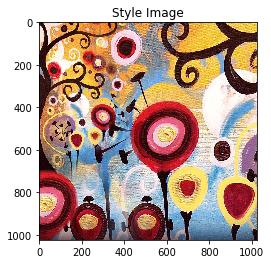

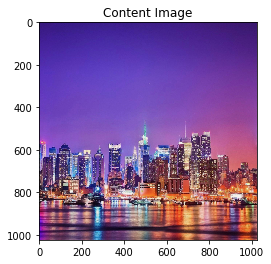

<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>


In [5]:
plt.figure()
image_show(style_img, title='Style Image')
plt.figure()
image_show(content_img, title='Content Image')

image = content_img.cpu().clone() 
image = image.squeeze(0)     
image = image_untransformer(image)
print(type(image))
image.save("content1_1024.jpg")

image = style_img.cpu().clone() 
image = image.squeeze(0)     
image = image_untransformer(image)
print(type(image))
image.save("style_1_1024.jpg")

# # Baseline style transfer

# img1 = cv2.imread('picasso.jpg')
# img2 = cv2.imread('dancing.jpg')
# img3 = cv2.resize(img1,(444,444))
# dst = cv2.addWeighted(img3,0.5,img2,0.5,0) # 0.5 is the ratio parameters

# print('style image')
# cv2_imshow(img3)
# print('\n')
# print('content image')
# cv2_imshow(img2)
# print('\n')
# print('transfered')
# cv2_imshow(dst)
# # cv2.waitKey(0)
# cv2.destroyAllWindows()

Loss Functions
--------------
Content Loss


<p style='font-size:15px'>By incorporating these two images(style image and content image) into our loss function, generating an image. We must punish deviations from the content of the content image and deviations from the style of the style image.

Input Feature Map:
    $\mathbb{R}^{H_\ell \times W_\ell \times C_\ell}$

Feature Map for the current map:
    $F^\ell \in \mathbb{R}^{M_\ell \times C_\ell}$
    

Feature Map for the goal map:
    $P^\ell \in \mathbb{R}^{M_\ell \times C_\ell}$ 
    
weight in the content function:
    $w_c$

Loss:
    $Loss = w_c \times \sum_{i,j} (F_{ij}^{\ell} - P_{ij}^{\ell})^2$



Style Loss

<p style='font-size:15px'> the style loss is for a layer. so assume we are calclulating the layer $\ell$

#### Gram matix:
<p style='font-size:15px'> 
    $F^\ell $ shape: $(M_\ell, C_\ell)$
    Gram matrix shape: $(C_\ell, C_\ell)$

and the function is:

$$G_{ij}^\ell  = \sum_k F^{\ell}_{k_i} F^{\ell}_{k_j}$$

#### loss function:
<p style='font-size:15px'> current image feature map gram matrix: $G^\ell$ 
<p style='font-size:15px'> source image feature map gram matirx: $A^\ell$ 
<p style='font-size:15px'> loss of style:
<p style='font-size:15px'> $$L_s^\ell = w_\ell \sum_{i, j} \left(G^\ell_{ij} - A^\ell_{ij}\right)^2$$
<p style='font-size:15px'>Total loss of all layers:

<p style='font-size:15px'>$$L_s = \sum_{\ell \in \mathcal{Layers}} L_s^\ell$$
    




# Get loss function




In [0]:
 def get_model(cnn, style_img, content_img):
    cnn = copy.deepcopy(cnn)
    Normal1 = Normal().to(device)
    content_losses = []
    style_losses = []
    model = nn.Sequential(Normal1)
    for index, layer in enumerate(cnn.children()):
        name = '{}'.format(index)
        model.add_module(name, layer)
        if index in [3, 8, 17, 22, 26, 35]:
            target_feature = model(style_img)
            style_loss = LossOfStyle(target_feature)
            style_losses.append(style_loss)
            model.add_module("{}_{}".format(index,"style"), style_loss)
            if index == 8:
                target_content = model(content_img)
                content_loss = LossOfContent(target_content)
                content_losses.append(content_loss)
                model.add_module("{}_{}".format(index,"content"), content_loss)
            if name == 35:
                break
    print(model)
    return model, style_losses, content_losses

class Normal(nn.Module):
    def __init__(self):
        super(Normal, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

class LossOfStyle(nn.Module):

    def __init__(self, target_feature):
        super(LossOfStyle, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()

    def forward(self, input):
        G = self.gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

    def gram_matrix(self, inputs):
        in_n, in_h, in_w, in_c =inputs.size()
        new_inputs_curr = inputs.view(in_n*in_h ,in_c * in_w)
        gram_matrix_result = torch.mm(new_inputs_curr,new_inputs_curr.t())
        all_G = gram_matrix_result.div(in_n * in_h * in_w * in_c)
        return all_G

class LossOfContent(nn.Module):
    def __init__(self,goal):
        super(LossOfContent,self).__init__()
        self.goal_feature = goal.detach()
        
    def forward(self,items):
        self.loss = F.mse_loss(items, self.goal_feature)
        return items


# Gradient Descent




In [0]:
def minimize_loss(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_model(cnn, style_img, content_img)
    print("Using LBFGS as optimizer")
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    print('Start Optimization')
    current_step=0
    while current_step <=num_steps:
    # for current_step in range(1,301):
      def compute_loss():
          nonlocal current_step
          current_step += 1
          optimizer.zero_grad()
          input_img.data.clamp_(0, 1)## clip the data of input to be between 0~1
          model(input_img)
          ## Using the sum of style_loss.loss to caculate the style loss score 
          style_loss_score=[style_loss.loss for style_loss in style_losses]
          ## Using the sum of content_loss.loss to caculate the content_loss score 
          content_loss_score=[content_loss.loss for content_loss in content_losses]
          style_loss_score=torch.stack(style_loss_score).sum()
          content_loss_score=torch.stack(content_loss_score).sum()
          ## using the weight of style loss and content loss to caculate the total loss
          loss = style_weight*style_loss_score + content_weight*content_loss_score
          loss.backward()
          if current_step % 30 == 0:
              print("current_step",current_step)
              sl=round(style_loss_score.item()*style_weight,5)
              cl=round(content_loss_score.item()*content_weight,5)
              print("Style Loss :",sl,"Content Loss :",cl)
              print("Total Loss :",sl+cl)
              plt.figure()
              image_show(input_img, title=' Image after {} iterations'.format(current_step))
          return loss
      optimizer.step(compute_loss)
    input_img.data.clamp_(0, 1)## clip the data of input to be between 0~1
    return input_img

# run

Building the style transfer model..
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (3_style): LossOfStyle()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (8_style): LossOfStyle()
  (8_content): LossOfContent()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=Tr

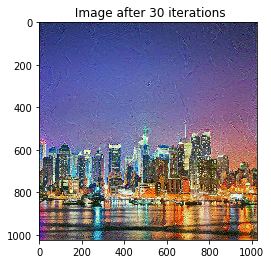

current_step 60
Style Loss : 0.22374 Content Loss : 0.43994
Total Loss : 0.66368


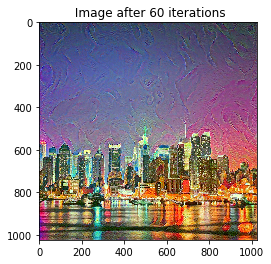

current_step 90
Style Loss : 0.10976 Content Loss : 0.39586
Total Loss : 0.50562


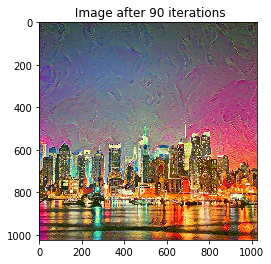

current_step 120
Style Loss : 0.08854 Content Loss : 0.36645
Total Loss : 0.45499


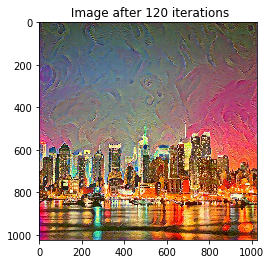

current_step 150
Style Loss : 0.08519 Content Loss : 0.35121
Total Loss : 0.4364


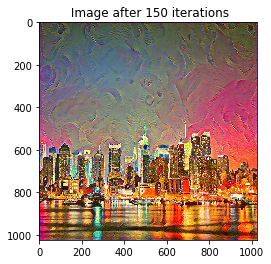

current_step 180
Style Loss : 0.08095 Content Loss : 0.34435
Total Loss : 0.4253


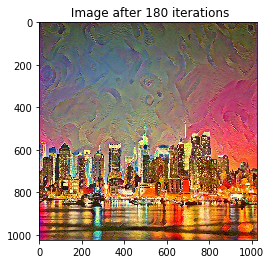

current_step 210
Style Loss : 0.07804 Content Loss : 0.33971
Total Loss : 0.41775


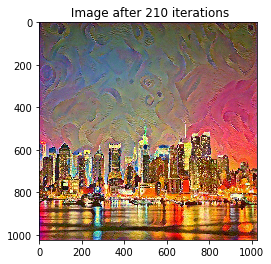

current_step 240
Style Loss : 0.07583 Content Loss : 0.33741
Total Loss : 0.41324


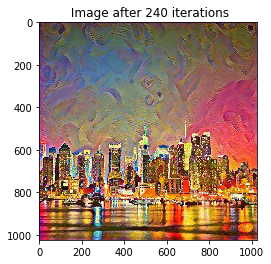

current_step 270
Style Loss : 0.07547 Content Loss : 0.33433
Total Loss : 0.4098


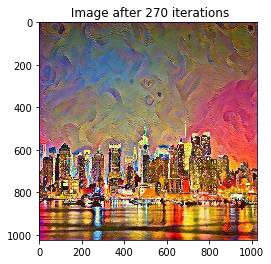

current_step 300
Style Loss : 0.07779 Content Loss : 0.33362
Total Loss : 0.41141000000000005


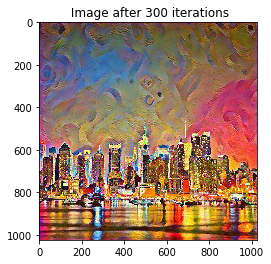

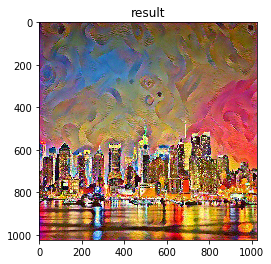

<class 'PIL.Image.Image'>


In [12]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
input_img = content_img.clone()
output = minimize_loss(cnn, content_img, style_img, input_img)
plt.figure()
image_show(output, title='result')
plt.ioff()
plt.show()

# save image 
image = output.cpu().clone() 
image = image.squeeze(0)     
image = image_untransformer(image)
print(type(image))
image.save("output.jpg")


In [13]:
 !ls

candy.jpg	   NY.jpeg     picasso_selfport1907.jpg  style_1_1024.jpg
content1_1024.jpg  output.jpg  pig.jpg
